In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
import re
import pickle as pk

In [2]:
path =  'c:/Git_Proyects/Tesis/Faiss_vect/'
citas = pk.load(open(path+'cita_media_cluster_august.pk', 'rb'))

In [12]:
index = 1401
df_clus_completo = pd.read_csv(path+f'Tw_mas_RT_august/RT_Tw_cluster_{index}.csv')
df_clus_completo['Fecha'] = pd.to_datetime(df_clus_completo['Fecha'], format='%a %b %d %H:%M:%S +0000 %Y')
df_clus_completo['HorasDesdeInicio'] = (df_clus_completo['Fecha'] - df_clus_completo['Fecha'].min()).dt.total_seconds() / 3600

categoria = 'RT'

df_categoria_true = df_clus_completo[df_clus_completo[categoria] == True]
df_categoria_false = df_clus_completo[df_clus_completo[categoria] == False]

df_categoria = [df_categoria_true, df_categoria_false]
labels = ['RT', 'Tw originales']

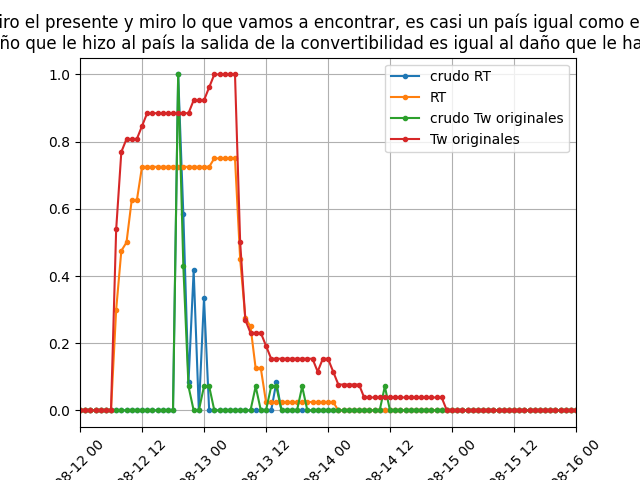

Timestamp('2019-08-13 02:00:00')

In [22]:
%matplotlib widget
plt.figure()
firstpart, secondpart = citas[index][:len(citas[index])//2], citas[index][len(citas[index])//2:]
plt.title(str(index)+'   ' + firstpart+'\n'+secondpart)
for i, df1 in enumerate(df_categoria):
    df = df1.copy()
    df_index = df.set_index('Fecha')
    df_count_hora = df_index.resample('1H').count()
    plt.plot(df_count_hora.index, df_count_hora['Tweets']/max(df_count_hora['Tweets']), label = 'crudo '+str(labels[i]), marker = '.') #Test comparation
    #plt.plot(df_count_hora.index, df_count_hora['Tweets'], label = 'crudo '+str(labels[i]), marker = '.') 
    df_suavizado = df_count_hora.rolling('1D', center = True).mean()
    df_suavizado_2 = df_count_hora.ewm( alpha = 0.1).mean()

    plt.plot(df_suavizado.index, df_suavizado['Tweets']/max(df_suavizado['Tweets']), label = labels[i], marker = '.', linestyle = 'solid')
    #plt.plot(df_suavizado_2.index, df_suavizado_2['Tweets'], label = 'filltro ewp', marker = '.', linestyle = 'solid', color = 'k')

#plt.xticks(pd.date_range(start=df_clus_completo['Fecha'].min(), end=df_clus_completo['Fecha'].max(), freq='12H')
#           , labels= (np.arange(df_clus_completo['HorasDesdeInicio'].min(), df_clus_completo['HorasDesdeInicio'].max(), 12)-336))
plt.legend()
plt.grid(0.7)
plt.xticks(rotation=45)
fecha_inicio = pd.to_datetime('2019-08-12')
fecha_fin = pd.to_datetime('2019-08-16')
plt.xlim([fecha_inicio, fecha_fin])
#plt.savefig(path+f'imagenes_agosto/serie_{index}.png')
plt.show()
indice_max_apariciones = df_suavizado['Tweets'].idxmax()

indice_max_apariciones

In [29]:
citas[46]

'ahora no hay nadie tomando deuda argentina ni nadie que pueda pagarla. argentina está en un default virtual, escondido'

Guardando todo junto, prueba

In [25]:
def graficar_y_guardar(list_df, citas, index):
    plt.figure()
    firstpart, secondpart = citas[index][:len(citas[index])//2], citas[index][len(citas[index])//2:]
    plt.title(str(index)+'   ' + firstpart+'\n'+secondpart)
    for i, df1 in enumerate(list_df):
        df = df1.copy()
        df_index = df.set_index('Fecha')
        df_count_hora = df_index.resample('1H').count()
        plt.plot(df_count_hora.index, df_count_hora['Tweets']/max(df_count_hora['Tweets']), label = 'crudo '+str(labels[i]), marker = '.') #Test comparation
        df_suavizado = df_count_hora.rolling('1D', center = True).mean()
        df_suavizado.index = pd.to_datetime(df_suavizado.index) - pd.Timedelta(hours=8)
        plt.plot(df_suavizado.index, df_suavizado['Tweets']/max(df_suavizado['Tweets']), label = labels[i], marker = '.', linestyle = 'solid')

    fecha_max_apariciones = df_suavizado['Tweets'].idxmax()
    fecha_inicio = fecha_max_apariciones - pd.Timedelta(days=1)
    fecha_fin = fecha_max_apariciones + pd.Timedelta(days=4)

    plt.legend()
    plt.grid(0.7)
    plt.xticks(rotation=45)
    # fecha_inicio = pd.to_datetime('2019-08-12')
    # fecha_fin = pd.to_datetime('2019-08-16')
    plt.xlim([fecha_inicio, fecha_fin])
    plt.savefig(path+f'imagenes_october/serie_{index}.png')
    plt.close()

In [26]:
path =  'c:/Git_Proyects/Tesis/Faiss_vect/'
citas = pk.load(open(path+'cita_media_cluster_october.pk', 'rb'))
archivos = os.listdir(path+'Tw_mas_RT_october')

for archivo in archivos:

    patron = re.compile(r'_(\d+).csv')
    coincidencia = patron.search(archivo)
    index = coincidencia.group(1)

    df_clus_completo = pd.read_csv(path+'Tw_mas_RT_october/'+archivo)
    df_clus_completo['Fecha'] = pd.to_datetime(df_clus_completo['Fecha'], format='%a %b %d %H:%M:%S +0000 %Y')  
    df_clus_completo['HorasDesdeInicio'] = (df_clus_completo['Fecha'] - df_clus_completo['Fecha'].min()).dt.total_seconds() / 3600
        
    categoria = 'RT'

    df_categoria_true = df_clus_completo[df_clus_completo[categoria] == True]
    df_categoria_false = df_clus_completo[df_clus_completo[categoria] == False]

    df_categoria = [df_categoria_true, df_categoria_false]
    labels = ['RT', 'Tw originales']
    graficar_y_guardar(df_categoria, citas, int(index))